#Dataset preparation

In [11]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn import model_selection

from numpy import argmax

In [12]:
!pip install hyperas
!pip install hyperopt

In [13]:
df = pd.read_csv('/content/drive/MyDrive/Project/dataset/train.csv')

In [14]:
#Prima di eseguire questo script sarebbe opportuno controllare che le date sono ordinate in ordine crescente

weather_names =['_temperature_','_rain_mm_','_humidity_','_wind_speed_','_pressure_']

for name in weather_names:
  df['max'+name+'prev14d']=df['max'+name+'prev7d']
  df['max'+name+'prev7d_shift']=df['max'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df['DATE']>'2019-04-16', 'max'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['max'+name+'prev7d','max'+name+'prev7d_shift']].max(axis=1)
  df=df.drop(columns=['max'+name+'prev7d_shift'])

  df['min'+name+'prev14d']=df['min'+name+'prev7d']
  df['min'+name+'prev7d_shift']=df['min'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'min'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['min'+name+'prev7d','min'+name+'prev7d_shift']].min(axis=1)
  df=df.drop(columns=['min'+name+'prev7d_shift'])

  df['mean'+name+'prev14d']=df['mean'+name+'prev7d']
  df['mean'+name+'prev7d_shift']=df['mean'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'mean'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['mean'+name+'prev7d','mean'+name+'prev7d_shift']].mean(axis=1)
  df=df.drop(columns=['mean'+name+'prev7d_shift'])

persistance_names =['equipment','fire/smoke','ge','power','temperature']

for name in persistance_names:
  df[name+'_max_persistance_prev14d']=df[name+'_max_persistance_prev7d']
  df[name+'_max_persistance_prev7d_shift']=df[name+'_max_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_max_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_max_persistance_prev7d',name+'_max_persistance_prev7d_shift']].max(axis=1)
  df=df.drop(columns=[name+'_max_persistance_prev7d_shift'])
  
  df[name+'_min_persistance_prev14d']=df[name+'_min_persistance_prev7d']
  df[name+'_min_persistance_prev7d_shift']=df[name+'_min_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_min_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_min_persistance_prev7d',name+'_min_persistance_prev7d_shift']].min(axis=1)
  df=df.drop(columns=[name+'_min_persistance_prev7d_shift'])

  df[name+'_mean_persistance_prev14d']=df[name+'_mean_persistance_prev7d']
  df[name+'_mean_persistance_prev7d_shift']=df[name+'_mean_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_mean_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_mean_persistance_prev7d',name+'_mean_persistance_prev7d_shift']].mean(axis=1)
  df=df.drop(columns=[name+'_mean_persistance_prev7d_shift'])

In [15]:
#drop unused columns
df = df.drop(columns='CELL_TYPE_TRP')
df = df.drop(columns='SITE_ID')

#process data feature
df['DATE'] = pd.to_datetime(df['DATE'])
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df['year'] = df['DATE'].dt.year % 2019
df = df.drop(columns='DATE')

In [16]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [17]:
def plot_roc_curve(y, predictions, ax):
    fpr, tpr, thresholds = roc_curve(y, predictions)
    ax.plot([0,1], [0,1], linestyle='--')
    ax.plot(fpr, tpr, marker='.', label='Random forest')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.plot()

def plot_precision_recall_curve(y, predictions, ax):
    precision, recall, thresholds = precision_recall_curve(y, predictions)
    no_skill = len(y[y==1]) / len(y)
    ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    ax.plot(recall, precision, marker='.', label='Random forest')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.legend()
    ax.plot()

def cyclical_encoding(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

#Random forest come SERGIO

In [18]:
df_14d_plus = df[[col for col in df.columns if '3d' not in col and '7d' not in col and 'CELL_TYPE_' not in col and 'year' not in col]]

df_14d_plus['day'] = df_14d_plus['day'] - 1
df_14d_plus = cyclical_encoding(df_14d_plus, 'day', 30)

df_14d_plus = df_14d_plus.drop(columns = ['day'])
df_14d_plus.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_f_next14d,max_temperature_f_next14d,min_temperature_f_next14d,mean_rain_mm_f_next14d,max_rain_mm_f_next14d,min_rain_mm_f_next14d,mean_humidity_f_next14d,max_humidity_f_next14d,min_humidity_f_next14d,mean_wind_speed_f_next14d,max_wind_speed_f_next14d,min_wind_speed_f_next14d,mean_pressure_f_next14d,max_pressure_f_next14d,min_pressure_f_next14d,equipment_sum_alarms_prev14d,fire/smoke_sum_alarms_prev14d,ge_sum_alarms_prev14d,power_sum_alarms_prev14d,temperature_sum_alarms_prev14d,skew_equipment_alarms_prev14d,skew_fire/smoke_alarms_prev14d,skew_ge_alarms_prev14d,skew_power_alarms_prev14d,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,max_temperature_prev14d,min_temperature_prev14d,mean_temperature_prev14d,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day_sin,day_cos
0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.00,12.0,5.0,4.79,19.6,0.1,74.29,89.0,58.0,12.86,17.0,5.0,1020.71,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,14.0,6.0,10.29,8.5,0.0,1.33,81.0,45.0,62.71,16.0,5.0,11.43,1022.0,1006.0,1013.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.951057,-0.309017
1,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.50,16.0,5.0,3.52,12.5,0.1,72.93,89.0,58.0,12.57,17.0,5.0,1021.71,1028.0,1013.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.71,8.5,0.0,1.90,81.0,51.0,66.43,16.0,5.0,11.57,1017.0,1006.0,1010.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.866025,-0.500000
2,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,9.36,20.0,5.0,3.63,12.5,0.1,72.00,89.0,58.0,12.29,17.0,5.0,1022.14,1028.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.57,19.6,0.0,4.70,88.0,58.0,71.71,16.0,5.0,11.71,1015.0,1006.0,1009.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.743145,-0.669131
3,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,10.57,22.0,5.0,3.40,12.5,0.1,70.07,89.0,58.0,12.14,17.0,5.0,1021.86,1028.0,1012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,8.0,11.29,19.6,0.0,4.77,88.0,58.0,74.29,16.0,5.0,11.43,1013.0,1006.0,1009.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.587785,-0.809017
4,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,11.50,22.0,5.0,3.49,12.5,0.1,69.07,89.0,58.0,11.64,17.0,5.0,1021.29,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,5.0,10.57,19.6,0.3,5.39,88.0,58.0,77.29,15.0,5.0,10.86,1016.0,1006.0,1009.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.406737,-0.913545


In [19]:
X = df_14d_plus.drop(columns=['aircon_sum_target_next14d'])
y = df_14d_plus['aircon_sum_target_next14d']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [21]:
nfold = 10
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)

target = 'aircon_sum_target_next14d'
predictors = X_train.columns

i = 1
models = []

for train_index, valid_index in skf.split(X_train, y_train):
  print("\nFold {}".format(i))

  clf_RandomForest = RandomForestClassifier(n_estimators = 20, random_state=0)
  model = clf_RandomForest.fit(X_train.iloc[train_index][predictors].values, 
                               y_train.iloc[train_index].values)

  models.append(model)
  i = i+1


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5

Fold 6

Fold 7

Fold 8

Fold 9

Fold 10


In [22]:
test_predictions = np.zeros(len(X_test))
pred = []
for mdl in models:
    pr = mdl.predict_proba(X_test[predictors])[:,1]
    test_predictions += pr/nfold
    pred.append(pr)

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)

f1 score:  0.7123088128186454
precision:  0.7180616740088106
recall: 0.7066473988439307
auc precision-recall:  0.7686181130039896


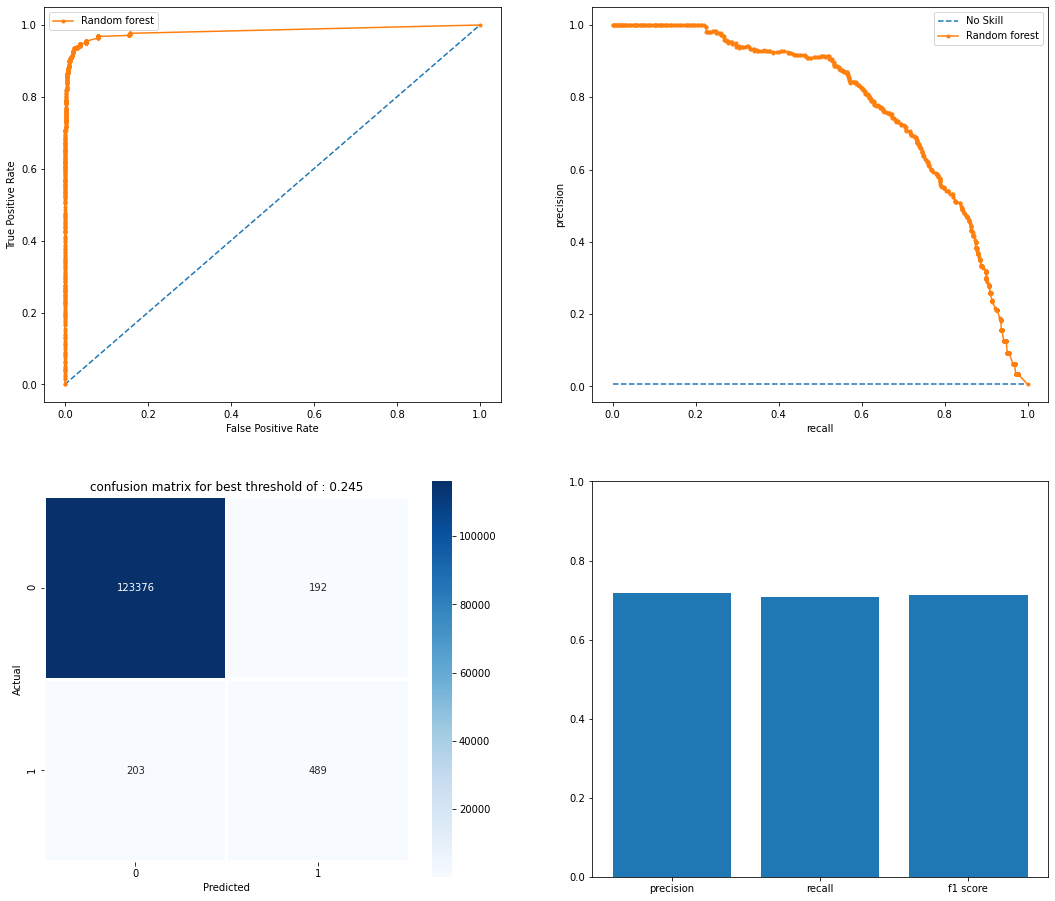

In [24]:
rectifier = lambda x, thr: 0 if x < thr else 1

f, axs = f, axs = plt.subplots(figsize= (18,16), ncols=2, nrows=2)
plot_roc_curve(y_test, test_predictions, axs[0][0])
precision, recall, thresholds = precision_recall_curve(y_test, test_predictions)
plot_precision_recall_curve(y_test, test_predictions, axs[0][1])

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
max_fscore = fscore[ix]
best_thr = thresholds[ix]
rectified = np.array([rectifier(x, best_thr) for x in test_predictions])

confusion_matrix = pd.crosstab(y_test.values, rectified, rownames=['Actual'], colnames=['Predicted'])
heatmap_title = 'confusion matrix for best threshold of : {thr:.3f}'
sns.heatmap(confusion_matrix, annot=True, fmt='d', square=True, cmap='Blues',
            ax=axs[1][0], robust=True, linewidth=2).set(title=heatmap_title.format(thr = best_thr));

max_precision = precision[ix]
max_recall = recall[ix]

x_bar = np.arange(3)
y_bar = np.array([max_precision, max_recall, max_fscore])
axs[1,1].set_ylim(0, 1)
axs[1,1].bar(x_bar, y_bar)
axs[1,1].set_xticks([0, 1, 2])
axs[1,1].set_xticklabels(['precision', 'recall', 'f1 score']);

print('f1 score: ', max_fscore)
print('precision: ', max_precision)
print('recall:', max_recall)
print('auc precision-recall: ', auc(recall, precision))

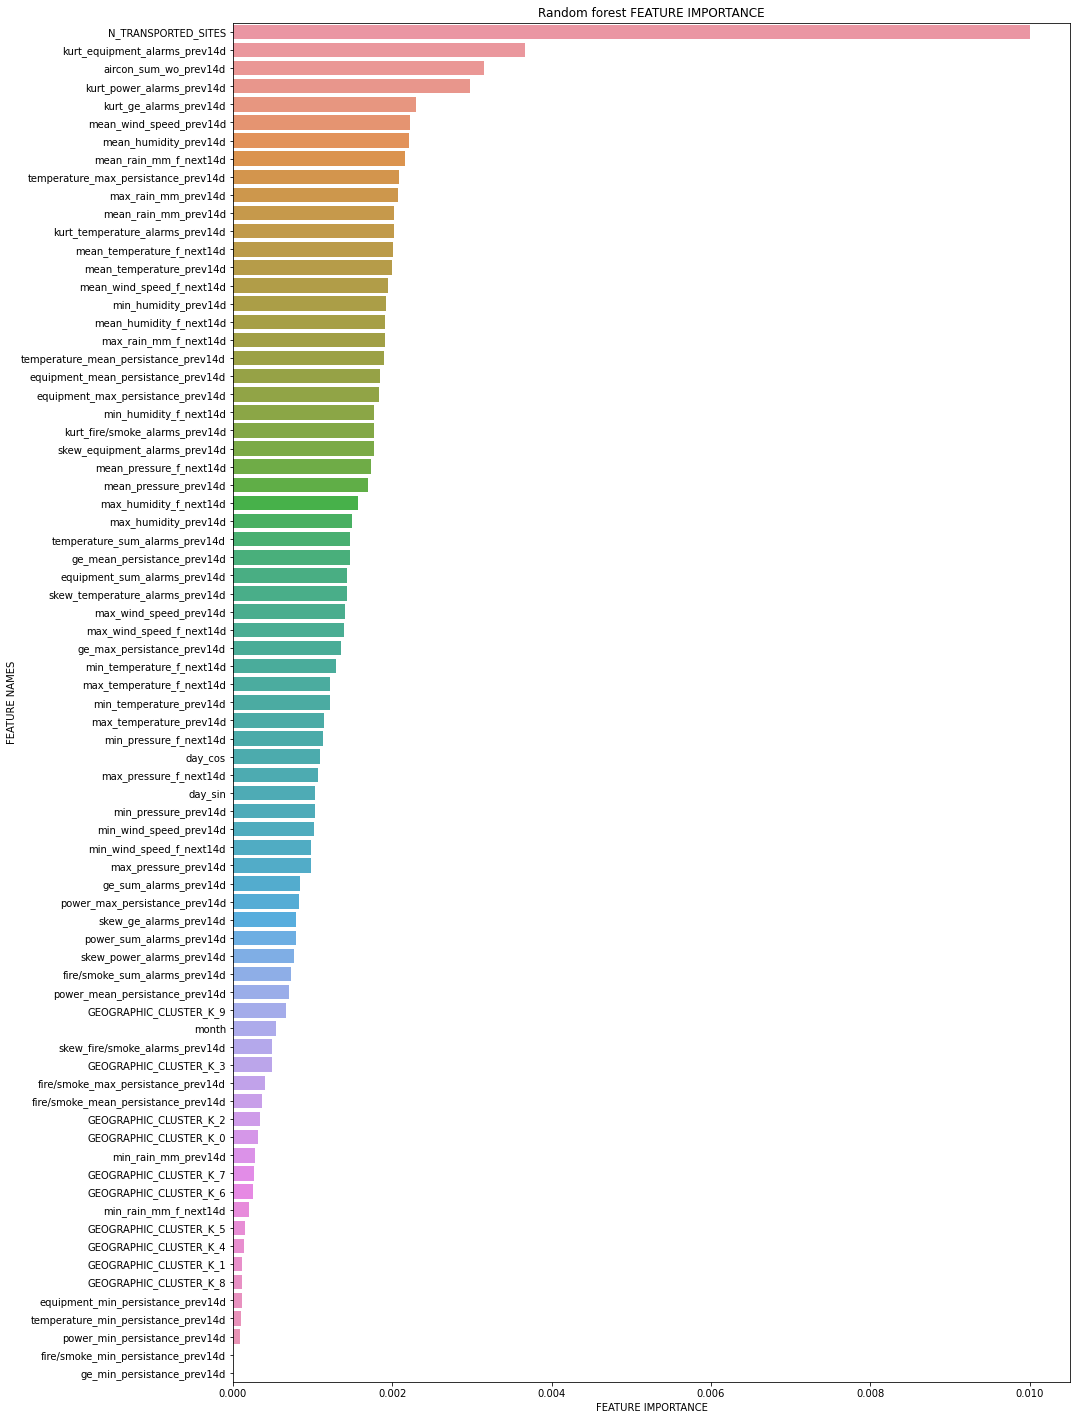

In [25]:
importance = np.zeros(len(X_test))
for mdl in models:
  importance =+ mdl.feature_importances_/nfold

plot_feature_importance(importance,X_test.columns, 'Random forest ')

#Tuning

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 90, num = 5)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap }
print(random_grid)

{'n_estimators': [50, 60, 70, 80, 90], 'max_features': ['auto'], 'max_depth': [5, 8, 12, 16, 20], 'min_samples_split': [2], 'min_samples_leaf': [1], 'bootstrap': [True]}


In [27]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = 4,error_score='raise')

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=100. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 15.3min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 51.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
           

In [28]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [29]:
rf_random.best_estimator_.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
y_pred = rf_random.best_estimator_.predict_proba(X_test)

In [ ]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('F1: ',metrics.f1_score(y_test, y_pred))